Installing some dependencies

In [1]:
%%capture
!pip install bitsandbytes accelerate transformers-interpret shap inseq

# Explainability


**Feature attribution methods** leverage the internal information (e.g. gradients, attention) or predictions of a model to quantify the relationship between its inputs and its predictions.

Attribution methods produce **importance scores** (or *saliency scores*) for every element of the input, reflecting the importance of every input element in driving the model prediction. These scores are often presented using <span style="background:#A85E9E">highlights</span> (or *attribution maps*) to facilitate comprehension, although recent research showed the risks of textual highlights misinterpretation caused by human cognitive biases ([Jacovi et al. 2022](https://dl.acm.org/doi/abs/10.1145/3531146.3533127), [Jacovi et al. 2023](https://arxiv.org/abs/2305.02679))

We can categorize feature attribution approaches in three major families:
- **Gradient-based methods** such as [Gradients]() and [Integrated gradients]() use gradients as a natural source of information to motivate model predictions. Gradients for model parameters computed in relation to a loss function are commonly used during training to update model parameters, since they represent *the magnitude of change needed for a parameter such that the prediction matches the target label*. In the case of feature attribution, gradients computed with respect to a model prediction logit or probability are instead taken as *how much the parameter is contributing towards the prediction*.

- **Surrogates models based on perturbation methods** such as [Occlusion](https://captum.ai/api/occlusion.html), [SHAP]() or [LIME]() estimate importance of inputs by introducing noise in the prediction process, usually by masking or removing either input features or network components, and verifying the downstream effect on model predictions. Intuitively, these can also be used to determine the importance of layers in the neural network.

- **Internals-based methods** use quantities computed naturally by the network during their predictions to motivate its internal computations. For Transformers-based model, [attention weights](https://aclanthology.org/D19-1002/) are commonly used, by themselves or multiplied with other quantities, as indications of feature importance.


**Note that:**
- We distinguish gradient and internals methods since gradient methods require a *prediction target* (e.g. the predicted class label, the next generated word) to compute importance scores, while internals-based one generally do not rely on the predicted output to determine importance.


# Explainability in representative transformers models



## Sentiment explainer (gradient-based approach)

In [1]:
%%capture
!pip install -U captum
!pip install transformers

In [3]:
!pip install --upgrade scipy==1.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 41.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.12.0 which is incompatible.


In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# With both the model and tokenizer initialized we are now able to get explanations on an example text.

from transformers_interpret import SequenceClassificationExplainer

cls_explainer = SequenceClassificationExplainer(
    model,
    tokenizer,
)
word_attributions = cls_explainer("I love you, I like you")
word_attributions

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

[('[CLS]', 0.0),
 ('i', 0.2778543531894684),
 ('love', 0.7792373299598694),
 ('you', 0.3856005072593689),
 (',', -0.017697645351290703),
 ('i', 0.1207190603017807),
 ('like', 0.1909111738204956),
 ('you', 0.3399486243724823),
 ('[SEP]', 0.0)]

Positive attribution numbers indicate a word contributes positively towards the predicted class, while negative numbers indicate a word contributes negatively towards the predicted class. Here we can see that I love you gets the most attention.



In [3]:
print(f'Predicted label {cls_explainer.predicted_class_index} aka {cls_explainer.predicted_class_name} label')

Predicted label 1 aka POSITIVE label


In [4]:
_ = cls_explainer.visualize()

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,POSITIVE (1.00),POSITIVE,2.08,"[CLS] i love you , i like you [SEP]"


Let's try with something more complicated:

In [5]:
word_attributions = cls_explainer("Your presence illuminates the room, drawing in positivity and fostering a sense of comfort for those around you")
print(f'Predicted label {cls_explainer.predicted_class_index} aka {cls_explainer.predicted_class_name} label')
_ = cls_explainer.visualize()

Predicted label 1 aka POSITIVE label


In [6]:
word_attributions = cls_explainer("Your lack of consideration for others' perspectives often creates unnecessary tension and limits constructive discussions.")
print(f'Predicted label {cls_explainer.predicted_class_index} aka {cls_explainer.predicted_class_name} label')
_ = cls_explainer.visualize()

Predicted label 0 aka NEGATIVE label


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,NEGATIVE (1.00),NEGATIVE,2.90,[CLS] your lack of consideration for others ' perspectives often creates unnecessary tension and limits constructive discussions . [SEP]


### Explaining Attributions for Non Predicted Class
Attribution explanations are not limited to the predicted class. Let's test a more complex sentence that contains mixed sentiments.

In the example below we pass `class_name="NEGATIVE"` as an argument indicating we would like the attributions to be explained for the **NEGATIVE** class regardless of what the actual prediction is. Effectively because this is a binary classifier we are getting the inverse attributions.




In [7]:
cls_explainer = SequenceClassificationExplainer(model, tokenizer)
attributions = cls_explainer("I love you, I like you, I also kinda dislike you", class_name="NEGATIVE")

In [8]:
print(f'Predicted label {cls_explainer.predicted_class_index} aka {cls_explainer.predicted_class_name} label')

Predicted label 1 aka POSITIVE label


In this case, `predicted_class_name` still returns a prediction of the **POSITIVE** class, because the model has generated the same prediction but nonetheless we are interested in looking at the attributions for the negative class regardless of the predicted result.



In [9]:
_ = cls_explainer.visualize()

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,POSITIVE (0.00),NEGATIVE,-1.63,"[CLS] i love you , i like you , i also kinda dislike you [SEP]"


But when we visualize the attributions we can see that the words "*...kinda dislike*" are contributing to a prediction of the "NEGATIVE" class.

Getting attributions for different classes is particularly insightful for multiclass problems as it allows you to inspect model predictions for a number of different classes and sanity-check that the model is "looking" at the right things.


## MultiLabel Classification explainer (gradient-based approach)

Let's download a model for sentiment classification. Possible sentiment are:
- sadness
- joy
- love
- anger
- fear
- surprise

In [10]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers_interpret import MultiLabelClassificationExplainer

tokenizer = AutoTokenizer.from_pretrained("nateraw/bert-base-uncased-emotion", use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained("nateraw/bert-base-uncased-emotion").cuda()

cls_explainer = MultiLabelClassificationExplainer(model, tokenizer)

word_attributions = cls_explainer("There were many aspects of the film I liked, but it was frightening and gross in parts. My parents hated it.")

_ = cls_explainer.visualize()

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [11]:
word_attributions = cls_explainer("Sunny summer mornings are really beautiful!")
_ = cls_explainer.visualize()

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
n/a,(0.17),sadness,-1.59,[CLS] sunny summer mornings are really beautiful ! [SEP]
n/a,(1.00),joy,1.72,[CLS] sunny summer mornings are really beautiful ! [SEP]
n/a,(0.65),love,0.95,[CLS] sunny summer mornings are really beautiful ! [SEP]
n/a,(0.18),anger,-1.15,[CLS] sunny summer mornings are really beautiful ! [SEP]
n/a,(0.12),fear,-1.12,[CLS] sunny summer mornings are really beautiful ! [SEP]
n/a,(0.25),surprise,1.80,[CLS] sunny summer mornings are really beautiful ! [SEP]


## MultiLabel Classification explainer (SHAP-based approach)

In [12]:
import shap
import transformers

# build a pipeline object to do predictions
pred = transformers.pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0,
    return_all_scores=True,
)

explainer = shap.Explainer(pred)

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In the plots below, when you hover your mouse over an output class you get the explanation for that output class. When you click an output class name then that class remains the focus of the explanation visualization until you click another class.

The base value is what the model outputs when the entire input text is masked. The SHAP values **explain in an addive way how the impact of unmasking each word changes the model output** from the base value (where the entire input is masked) to the final prediction value.

In [13]:
shap_values = explainer([
    "I love you, I like you",
    "Sunny summer mornings are really beautiful!",
    "I would like to go to the sea but I am too far away to go",
])
shap.plots.text(shap_values)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


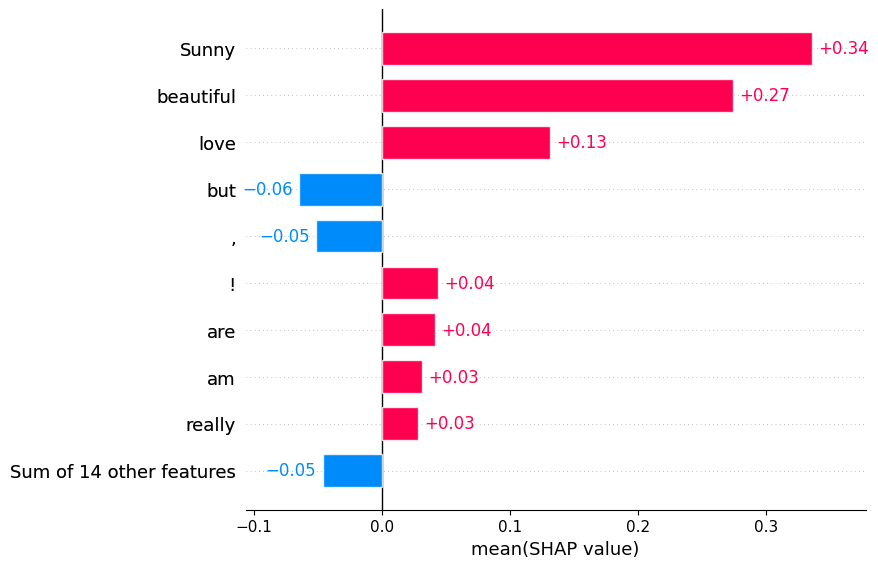

In [14]:
shap.plots.bar(shap_values[:, :, "joy"].mean(0))

## Token classification (NER) explainer (gradient-based)

Let's start by initializing a transformers' Token Classfication model and tokenizer, and running it through the `TokenClassificationExplainer`.

For this example we are using `dslim/bert-base-NER`, a bert model finetuned on the CoNLL-2003 **Named Entity Recognition** dataset.




In [15]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
from transformers_interpret import TokenClassificationExplainer

# model for [location, person] recognition
model = AutoModelForTokenClassification.from_pretrained('dslim/bert-base-NER')
tokenizer = AutoTokenizer.from_pretrained('dslim/bert-base-NER')

ner_explainer = TokenClassificationExplainer(
    model,
    tokenizer,
)

sample_text = "We visited Paris last weekend, where Emmanuel Abc lives."

word_attributions = ner_explainer(
    sample_text,
    ignored_labels=['O']
)

config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [16]:
_ = ner_explainer.visualize()

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
B-LOC,B-LOC (1.00),Paris,0.91,"[CLS] We visited Paris last weekend , where Emmanuel A ##b ##c lives . [SEP]"
B-PER,B-PER (1.00),Emmanuel,1.13,"[CLS] We visited Paris last weekend , where Emmanuel A ##b ##c lives . [SEP]"
I-PER,I-PER (1.00),A,1.18,"[CLS] We visited Paris last weekend , where Emmanuel A ##b ##c lives . [SEP]"
I-PER,I-PER (1.00),##b,1.61,"[CLS] We visited Paris last weekend , where Emmanuel A ##b ##c lives . [SEP]"
I-PER,I-PER (0.71),##c,1.16,"[CLS] We visited Paris last weekend , where Emmanuel A ##b ##c lives . [SEP]"


# Explainability in Generative transformers models

Of course, the various explainability techniques can also be applied to generative models, which have the task of generating text from a context (or prompt).

The operation is quite similar, but in this case, **each generated token represents a 'label'** that can be analysed.
- Why was this particular token generated?
- What was the model based on to generate this token?

In [17]:
import inseq

model = inseq.load_model(
    "gpt2",
    "integrated_gradients",     # we can select different attribution techiniques such us input_x_gradient, integrated_gradients, gradient_shap, lime, ...
)
model.attribute(
    "Hello ladies and",
    generation_args={"max_new_tokens": 9},
    n_steps=500,
    internal_batch_size=50
).show()

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
Attributing with integrated_gradients...: 100%|██████████| 12/12 [00:07<00:00,  1.25it/s]


,Ġgentlemen,",",ĠI,Ġam,Ġa,Ġmember,Ġof,Ġthe,ĠBoard
Hello,0.244,0.163,0.133,0.241,0.068,0.191,0.078,0.07,0.152
Ġladies,0.477,0.161,0.189,0.251,0.08,0.225,0.08,0.054,0.15
Ġand,0.279,0.304,0.216,0.071,0.268,0.079,0.045,0.187,0.056
Ġgentlemen,,0.372,0.207,0.247,0.079,0.228,0.095,0.083,0.205
",",,,0.255,0.066,0.205,0.071,0.043,0.169,0.039
ĠI,,,,0.124,0.076,0.05,0.042,0.031,0.047
Ġam,,,,,0.225,0.076,0.034,0.044,0.048
Ġa,,,,,,0.08,0.073,0.09,0.044
Ġmember,,,,,,,0.509,0.083,0.197
Ġof,,,,,,,,0.189,0.025


Let's see if the models can really **"""reason"""** on math:

In [18]:
model = inseq.load_model(
    "gpt2",
    "input_x_gradient",     # we can select different attribution techiniques such us input_x_gradient, integrated_gradients, gradient_shap, lime, ...
)
model.attribute(
    "2+2=4, 5+5=10, 11+11=",        # 11
    generation_args={"max_new_tokens": 1},
    n_steps=500,
    internal_batch_size=50
).show()

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Attributing with input_x_gradient...: 100%|██████████| 17/17 [00:00<00:00, 26.08it/s]


,20
2,0.054
+,0.074
2,0.049
=,0.071
4,0.045
",",0.037
Ġ5,0.047
+,0.068
5,0.036
=,0.081


Note how here the different **tokens generated may not only refer to the starting prompt (the input)** but, being more than one, **may also refer to several previous tokens generated** by the model itself!

### Machine Translation task

In [19]:
import inseq

# Load the model Helsinki-NLP/opus-mt-en-fr (6-layer encoder-decoder transformer) from the
# Huggingface Hub and hook it with the Input X Gradient feature attribution method
model = inseq.load_model("Helsinki-NLP/opus-mt-en-it", "input_x_gradient")

# Generate the translation for input_texts and attribute inputs at every steps of the generation
# attribute_target=True is used to include the target prefix in the attributed inputs (2nd matrix)
# step scores are computed at every step and returned alongsides attribution scores
out = model.attribute(
    input_texts="Hello everyone, hope you're enjoying the lecture!",
    attribute_target=True,
    step_scores=["probability"],
)
# Visualize the attributions and step scores
out.show()

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/789k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/814k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:177: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")

Attributing with input_x_gradient...:   6%|▌         | 1/18 [00:00<?, ?it/s]Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.

Attributing with input_x_gradient...: 100%|██████████| 18/18 [00:01<00:00, 16.48it/s]


,▁Ci,a,o,▁a,▁tutti,",",▁spero,▁vi,▁stia,te,▁gode,ndo,▁la,▁le,zione,!,</s>
▁H,0.134,0.1,0.063,0.052,0.048,0.07,0.038,0.044,0.05,0.018,0.009,0.013,0.007,0.005,0.003,0.02,0.006
ello,0.183,0.152,0.082,0.092,0.07,0.082,0.045,0.056,0.059,0.018,0.011,0.017,0.008,0.006,0.003,0.023,0.008
▁everyone,0.134,0.123,0.049,0.163,0.144,0.058,0.047,0.042,0.037,0.02,0.012,0.016,0.008,0.007,0.003,0.016,0.006
",",0.064,0.039,0.026,0.042,0.031,0.045,0.051,0.03,0.024,0.01,0.007,0.009,0.005,0.004,0.002,0.011,0.002
▁hope,0.103,0.049,0.033,0.043,0.031,0.058,0.221,0.072,0.047,0.032,0.026,0.02,0.008,0.007,0.003,0.014,0.004
▁you,0.035,0.017,0.016,0.018,0.014,0.029,0.042,0.027,0.028,0.018,0.011,0.01,0.005,0.005,0.002,0.008,0.003
',0.034,0.015,0.021,0.014,0.011,0.037,0.036,0.028,0.043,0.02,0.014,0.009,0.006,0.006,0.003,0.009,0.003
re,0.033,0.012,0.019,0.016,0.011,0.034,0.029,0.029,0.043,0.016,0.015,0.008,0.006,0.004,0.002,0.009,0.002
▁enjoying,0.092,0.031,0.042,0.028,0.031,0.081,0.097,0.139,0.196,0.13,0.173,0.064,0.026,0.018,0.008,0.027,0.011
▁the,0.025,0.014,0.013,0.01,0.009,0.018,0.023,0.029,0.041,0.026,0.035,0.014,0.017,0.018,0.009,0.008,0.005


In [20]:
import inseq

model = inseq.load_model("Helsinki-NLP/opus-mt-en-it", "input_x_gradient")

out = model.attribute(
    input_texts="The doctor was pregnant",
    attribute_target=True,
    step_scores=["probability"],
)
# Visualize the attributions and step scores
out.show()

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Attributing with input_x_gradient...: 100%|██████████| 8/8 [00:01<00:00,  5.21it/s]


,▁Il,▁dotto,re,▁era,▁incinta,.,</s>
▁The,0.177,0.172,0.082,0.117,0.137,0.068,0.104
▁doctor,0.235,0.245,0.16,0.128,0.187,0.1,0.127
▁was,0.169,0.162,0.064,0.136,0.134,0.068,0.097
▁pregnant,0.292,0.278,0.131,0.358,0.318,0.158,0.171
</s>,0.127,0.12,0.06,0.112,0.134,0.049,0.062
probability,0.754,0.432,0.908,0.866,0.569,0.479,0.842
,▁Il,▁dotto,re,▁era,▁incinta,.,</s>
<pad>,0.0,0.0,0.0,0.0,0.0,0.0,0.0
▁Il,,0.024,0.059,0.043,0.013,0.119,0.028
▁dotto,,,0.444,0.07,0.033,0.126,0.039


### Question-Answering task

In [21]:
import inseq

context = (
    "Interstellar is a 2014 epic science fiction film co-written, directed, and produced by Christopher Nolan."
    "Set in a dystopian future where humanity is embroiled in a catastrophic blight and famine, "
    "the film follows a group of astronauts who travel through a wormhole near Saturn in search of a new home for humankind."
)
# question = "When did the film interstellar come out?"
# question = "Who directed interstellar?"
question = "Where do the astronauts go in the film interstellar?"


context_and_question = context + "\nQuestion: " + question

qa_model = inseq.load_model("consciousAI/question-answering-generative-t5-v1-base-s-q-c", "input_x_gradient")
out = qa_model.attribute(context_and_question, attribute_target=True, step_scores=["probability"])

# Aggregate only source tokens, leave target tokens as they are
out.aggregate("subwords", aggregate_target=False).show()

config.json:   0%|          | 0.00/793 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Attributing with input_x_gradient...: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


,▁near,▁Saturn,</s>
▁Interstellar,0.02,0.02,0.035
▁is,0.005,0.004,0.007
▁a,0.004,0.003,0.005
▁2014,0.01,0.006,0.009
▁epic,0.006,0.006,0.009
▁science,0.004,0.006,0.007
▁fiction,0.006,0.007,0.01
▁film,0.008,0.009,0.01
"▁co-written,",0.004,0.004,0.008
"▁directed,",0.003,0.003,0.006


In [22]:
import inseq

context = (
    "Interstellar is a 2014 epic science fiction film co-written, directed, and produced by Christopher Nolan."
    "Set in a dystopian future where humanity is embroiled in a catastrophic blight and famine, "
    "the film follows a group of astronauts who travel through a wormhole near Saturn in search of a new home for humankind."
)
# question = "When did the film interstellar come out?"
# question = "Who directed interstellar?"
question = "Where do the astronauts go in the film interstellar?"


context_and_question = context + "\nQuestion: " + question

qa_model = inseq.load_model("ielabgroup/BiTAG-t5-large", "input_x_gradient")
out = qa_model.attribute(context_and_question, attribute_target=True, step_scores=["probability"])

# Aggregate only source tokens, leave target tokens as they are
out.aggregate("subwords", aggregate_target=False).show()

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]


Attributing with input_x_gradient...: 100%|██████████| 21/21 [00:06<00:00,  3.03it/s]


,▁Inter,s,tell,ar,:,▁Where,▁do,▁the,▁astronaut,s,▁go,▁in,▁the,▁film,▁inter,s,tell,ar,?,</s>
▁Interstellar,0.07,0.087,0.144,0.085,0.057,0.027,0.023,0.018,0.02,0.054,0.019,0.02,0.039,0.018,0.033,0.067,0.098,0.079,0.028,0.015
▁is,0.009,0.011,0.009,0.008,0.015,0.008,0.008,0.006,0.005,0.01,0.005,0.006,0.009,0.006,0.008,0.009,0.009,0.008,0.007,0.005
▁a,0.007,0.008,0.007,0.006,0.008,0.005,0.005,0.004,0.003,0.006,0.003,0.004,0.005,0.005,0.005,0.005,0.005,0.005,0.004,0.003
▁2014,0.012,0.014,0.01,0.011,0.019,0.009,0.008,0.005,0.005,0.011,0.006,0.006,0.011,0.014,0.008,0.007,0.008,0.006,0.011,0.007
▁epic,0.016,0.01,0.007,0.01,0.014,0.009,0.008,0.007,0.007,0.009,0.007,0.007,0.01,0.029,0.009,0.007,0.007,0.006,0.008,0.006
▁science,0.008,0.008,0.007,0.007,0.009,0.007,0.004,0.006,0.006,0.007,0.005,0.005,0.007,0.01,0.006,0.006,0.006,0.006,0.006,0.006
▁fiction,0.009,0.011,0.014,0.009,0.013,0.01,0.007,0.006,0.006,0.01,0.006,0.007,0.01,0.01,0.008,0.008,0.009,0.008,0.006,0.006
▁film,0.009,0.012,0.007,0.008,0.013,0.007,0.007,0.006,0.005,0.01,0.008,0.008,0.01,0.017,0.01,0.009,0.008,0.007,0.006,0.005
"▁co-written,",0.012,0.01,0.009,0.007,0.012,0.009,0.013,0.005,0.01,0.009,0.008,0.005,0.01,0.011,0.007,0.007,0.007,0.006,0.007,0.006
"▁directed,",0.006,0.007,0.005,0.005,0.007,0.005,0.004,0.003,0.004,0.007,0.004,0.004,0.005,0.005,0.005,0.005,0.005,0.004,0.004,0.004


Try yourself to challenge the model so that it errs in response:
- Does the way of asking the question and the terms used challenge the model?
- Is negation relevant in producing the correct answer in open question answering models like the one we used in the previous example?


In [23]:
import inseq

context = (
    "Provide some context"
)
question = ""

context_and_question = context + "\nQuestion: " + question

qa_model = inseq.load_model("consciousAI/question-answering-generative-t5-v1-base-s-q-c", "input_x_gradient")
out = qa_model.attribute(context_and_question, attribute_target=True, step_scores=["probability"])

# Aggregate only source tokens, leave target tokens as they are
out.aggregate("subwords", aggregate_target=False).show()

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.

Attributing with input_x_gradient...: 100%|██████████| 5/5 [00:00<00:00,  6.85it/s]


,▁provide,▁some,▁context,</s>
▁Provide,0.256,0.241,0.189,0.194
▁some,0.138,0.249,0.115,0.097
▁context,0.225,0.193,0.32,0.181
▁Question:,0.121,0.076,0.06,0.092
▁,0.056,0.032,0.022,0.044
</s>,0.078,0.078,0.087,0.066
probability,0.5,1.0,1.0,0.999
,▁provide,▁some,▁context,</s>
<pad>,0.127,0.054,0.059,0.051
▁provide,,0.077,0.052,0.058


### Summarization

In [24]:
import inseq

context = (
    "Interstellar is a 2014 epic science fiction film co-written, directed, and produced by Christopher Nolan."
    "Set in a dystopian future where humanity is embroiled in a catastrophic blight and famine, "
    "the film follows a group of astronauts who travel through a wormhole near Saturn in search of a new home for humankind."
)
# question = "When did the film interstellar come out?"
# question = "Who directed interstellar?"
question = "summarize the above text"


context_and_question = context + "\nQuestion: " + question

qa_model = inseq.load_model("consciousAI/question-answering-generative-t5-v1-base-s-q-c", "input_x_gradient")
out = qa_model.attribute(context_and_question, attribute_target=True, step_scores=["probability"])

# Aggregate only source tokens, leave target tokens as they are
out.aggregate("subwords", aggregate_target=False).show()

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Attributing with input_x_gradient...: 100%|██████████| 18/18 [00:02<00:00,  6.10it/s]


,▁,a,▁group,▁of,▁astronaut,s,▁who,▁travel,▁through,▁,a,▁,worm,hole,▁near,▁Saturn,</s>
▁Interstellar,0.045,0.029,0.022,0.022,0.018,0.011,0.017,0.021,0.018,0.019,0.015,0.02,0.025,0.017,0.018,0.021,0.014
▁is,0.006,0.006,0.007,0.005,0.004,0.003,0.004,0.005,0.004,0.004,0.003,0.004,0.003,0.003,0.003,0.003,0.004
▁a,0.006,0.005,0.005,0.005,0.003,0.004,0.004,0.005,0.003,0.003,0.003,0.004,0.002,0.004,0.002,0.003,0.002
▁2014,0.006,0.006,0.006,0.005,0.004,0.003,0.004,0.004,0.004,0.005,0.003,0.004,0.003,0.003,0.004,0.004,0.003
▁epic,0.008,0.007,0.009,0.008,0.005,0.004,0.006,0.006,0.005,0.006,0.006,0.007,0.005,0.004,0.004,0.003,0.004
▁science,0.007,0.008,0.007,0.007,0.015,0.005,0.006,0.007,0.006,0.007,0.006,0.007,0.005,0.005,0.005,0.005,0.004
▁fiction,0.015,0.014,0.014,0.01,0.011,0.008,0.01,0.01,0.008,0.008,0.007,0.009,0.006,0.007,0.007,0.007,0.006
▁film,0.014,0.015,0.015,0.013,0.011,0.008,0.01,0.01,0.009,0.008,0.008,0.01,0.007,0.006,0.006,0.01,0.008
"▁co-written,",0.016,0.01,0.007,0.011,0.007,0.005,0.009,0.009,0.008,0.012,0.009,0.009,0.006,0.008,0.006,0.007,0.006
"▁directed,",0.007,0.008,0.006,0.006,0.005,0.005,0.006,0.007,0.005,0.007,0.007,0.007,0.005,0.008,0.004,0.006,0.005


In [25]:
import inseq

context = (
    "Interstellar is a 2014 epic science fiction film co-written, directed, and produced by Christopher Nolan."
    "Set in a dystopian future where humanity is embroiled in a catastrophic blight and famine, "
    "the film follows a group of astronauts who travel through a wormhole near Saturn in search of a new home for humankind."
)
# question = "When did the film interstellar come out?"
# question = "Who directed interstellar?"
question = "summarize the above text"


context_and_question = context + "\nQuestion: " + question

qa_model = inseq.load_model("google/flan-t5-base", "input_x_gradient")
out = qa_model.attribute(context_and_question, attribute_target=True, step_scores=["probability"])

# Aggregate only source tokens, leave target tokens as they are
out.aggregate("subwords", aggregate_target=False).show()

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Attributing with input_x_gradient...: 100%|██████████| 22/22 [00:03<00:00,  6.23it/s]


,▁Inter,s,tell,ar,▁is,▁,a,▁2014,▁epic,▁science,▁fiction,▁film,▁co,-,written,",",▁directed,",",▁and,▁produced,</s>
▁Interstellar,0.061,0.237,0.328,0.232,0.045,0.04,0.035,0.029,0.031,0.03,0.025,0.027,0.03,0.024,0.022,0.019,0.023,0.016,0.026,0.022,0.023
▁is,0.016,0.025,0.018,0.017,0.024,0.018,0.019,0.02,0.025,0.016,0.022,0.02,0.02,0.021,0.021,0.015,0.014,0.014,0.013,0.016,0.014
▁a,0.008,0.016,0.014,0.023,0.015,0.04,0.012,0.027,0.044,0.022,0.034,0.03,0.028,0.011,0.017,0.015,0.011,0.013,0.01,0.009,0.014
▁2014,0.015,0.016,0.01,0.009,0.028,0.027,0.021,0.08,0.032,0.025,0.026,0.026,0.025,0.022,0.021,0.019,0.019,0.021,0.021,0.021,0.021
▁epic,0.011,0.01,0.008,0.01,0.015,0.048,0.017,0.025,0.105,0.044,0.023,0.024,0.021,0.011,0.013,0.018,0.01,0.013,0.012,0.011,0.013
▁science,0.009,0.008,0.007,0.007,0.008,0.023,0.01,0.016,0.05,0.121,0.035,0.019,0.014,0.009,0.011,0.009,0.007,0.006,0.007,0.006,0.007
▁fiction,0.013,0.012,0.012,0.009,0.016,0.027,0.015,0.018,0.031,0.054,0.07,0.026,0.018,0.012,0.018,0.014,0.012,0.012,0.012,0.013,0.011
▁film,0.012,0.014,0.01,0.011,0.017,0.015,0.013,0.017,0.021,0.018,0.014,0.064,0.018,0.021,0.023,0.014,0.018,0.013,0.015,0.018,0.012
"▁co-written,",0.012,0.014,0.008,0.006,0.015,0.015,0.011,0.013,0.013,0.011,0.01,0.012,0.064,0.115,0.143,0.035,0.034,0.019,0.022,0.021,0.019
"▁directed,",0.009,0.009,0.004,0.005,0.009,0.009,0.007,0.012,0.006,0.006,0.006,0.006,0.011,0.024,0.031,0.028,0.094,0.042,0.031,0.023,0.015
